### Sods Shock Tube Problem: Using FDM (Richtmyer Scheme)


### Problem situation description in brief
Picture a tube with two regions containing gas at different pressures, separated by an infinitely-thin, rigid diaphragm. The gas is initially at rest, and the left region is at a higher pressure than the region to the right of the diaphragm. At time $t = 0.0 s$, the diaphragm is ruptured instantaneously.  

What happens?  

You get a shock wave.  The gas at high pressure, no longer constrained by the diaphragm, rushes into the lower-pressure area and a one-dimensional unsteady flow is established, consisting of:

* a shock wave traveling to the right
* an expansion wave traveling to the left
* a moving contact discontinuity

The shock-tube problem is an example of a *Riemann problem* and it has an analytical solution, as we said. The situation is illustrated in Figure 1.

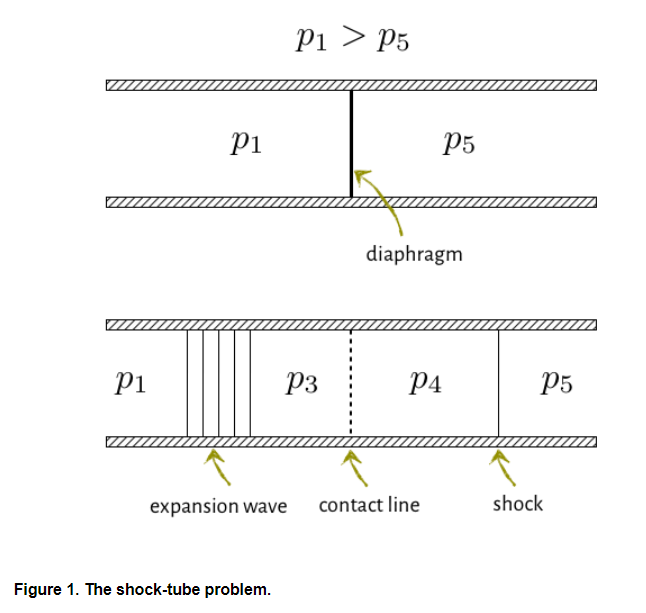

### Initial conditions
He first test proposed by Sod in his 1978 paper is as follows.  

In a tube spanning from $x = -10 \text{m}$ to $x = 10 \text{m}$ with the rigid membrane at $x = 0 \text{m}$, we have the following initial gas states:

$$
\underline{IC}_L =
\left[
    \begin{array}{c}
        \rho_L \\
        u_L \\
        p_L \\
    \end{array}
\right] =
\left[
    \begin{array}{c}
        1.0 \, kg/m^3 \\
        0 \, m/s \\
        100 \, kN/m^2 \\
    \end{array}
\right]
$$

$$
\underline{IC}_R =
\left[
    \begin{array}{c}
        \rho_R \\
        u_R \\
        p_R \\
    \end{array}
\right] =
\left[
    \begin{array}{c}
        0.125 \, kg/m^3 \\
        0 \, m/s \\
        10 \, kN/m^2 \\
    \end{array}
\right]
$$


In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
#Set the parameters

#left side of tube
rho_L = 1.0 #kg/m3
vel_L = 0.0 #m/s
P_L = 100000 #N/m3

#right side of tube
rho_R = 0.125 #kg/m3
vel_R = 0.0 #m/s
P_R = 10000 #N/m3

nx = 81
dx = 0.25
dt = 0.0002
gamma = 1.4
nt = 100

nt_req = 0.01/dt
print(dx, dt, nx, nt, nt_req)

x = numpy.linspace(-10.0, 10.0, num = nx)

0.25 0.0002 81 100 50.0


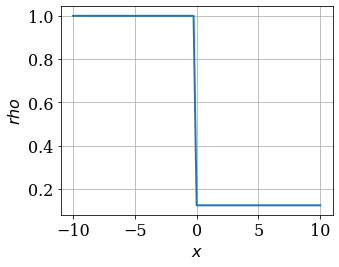

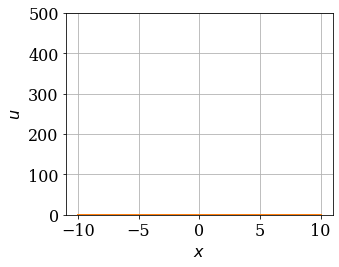

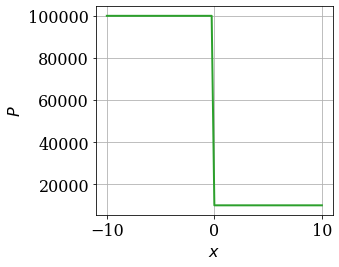

In [4]:
#Initial condition

rho0 = rho_L*numpy.ones_like(x)
mask = numpy.where(x>=0)
rho0[mask] = rho_R

u0 = vel_L*numpy.ones_like(x)
u0[mask] = vel_R

P0 = P_L*numpy.ones_like(x)
P0[mask] = P_R

#Plotting initial condition of rho
fig_rho = pyplot.figure(figsize=(5.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$rho$')
pyplot.grid()
line_rho = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

#Plotting initial condition of u
fig_u = pyplot.figure(figsize=(5.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$u$')
pyplot.grid()
line_u = pyplot.plot(x, u0, 
                    color = 'C1', linestyle = '-', linewidth = 2)[0]
#pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 500)
pyplot.tight_layout()

#Plotting initial condition of P
fig_P = pyplot.figure(figsize=(5.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$P$')
pyplot.grid()
line_P = pyplot.plot(x, P0, 
                    color = 'C2', linestyle = '-', linewidth = 2)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

## The Equations
The Euler equations govern the motion of an inviscid fluid (no viscosity).

Let's consider a 1D flow with velocity $u$ in the $x$-direction. The Euler equations for a fluid with density $\rho$ and pressure $p$ are:

1) Conservation of mass:
$$
\begin{align}
\frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}(\rho u) &= 0 \end{align}
$$

2) Conservation of momentum
$$
\begin{align}
\frac{\partial}{\partial t}(\rho u) + \frac{\partial}{\partial x} (\rho u^2 + p)&=0
\end{align}
$$

3) Energy Equation
$$
\begin{align}
\frac{\partial}{\partial t}(\rho e_T) + \frac{\partial}{\partial x} (\rho u e_T +p u)=0
\end{align}
$$
where $e_T=e+u^2/2$ is the total energy per unit mass, equal to the internal energy plus the kinetic energy (per unit mass).

Here is the vector representation of the Euler equation:

$$
\begin{equation}
\frac{\partial }{\partial t} \underline{\mathbf{u}} + \frac{\partial }{\partial x} \underline{\mathbf{f}} = 0
\end{equation}
$$

$$
\underline{\mathbf{f}} = f(\underline{\mathbf{u}})
$$

In order to get everything squared away, we need to represent $\underline{\mathbf{f}}$ in terms of $\underline{\mathbf{u}}$.
We can introduce a little shorthand for the $\underline{\mathbf{u}}$ and $\underline{\mathbf{f}}$ vectors and define:

$$
\underline{\mathbf{u}} =
\left[
    \begin{array}{c}
        u_1 \\
        u_2 \\
        u_3 \\
    \end{array}
\right] =
\left[
    \begin{array}{c}
        \rho \\
        \rho u \\
        \rho e_T \\
    \end{array}
\right]
$$

$$
\underline{\mathbf{f}} =
\left[
    \begin{array}{c}
        f_1 \\
        f_2 \\
        f_3 \\
    \end{array}
\right] =
\left[
    \begin{array}{c}
        \rho u \\
        \rho u^2 + p \\
        (\rho e_T + p) u \\
    \end{array}
\right]
$$  
where $p$ is the pressure of the fluid.

If we put together the conserved variables and the flux vector into our PDE, we get the following set of equations:

$$
\begin{equation}
    \frac{\partial}{\partial t}
    \left[
        \begin{array}{c}
            \rho \\
            \rho u \\
            \rho e_T \\
        \end{array}
    \right] +
    \frac{\partial}{\partial x}
    \left[
        \begin{array}{c}
            \rho u \\
            \rho u^2 + p \\
            (\rho e_T + p) u \\
        \end{array}
    \right] =
    0
\end{equation}
$$

### Calculating the Pressure 

For an ideal gas, the equation of state is

$$
e = e(\rho, p) = \frac{p}{(\gamma -1) \rho}
$$

where $\gamma = 1.4$ is a reasonable value to model air, 

$$
\therefore p = (\gamma -1)\rho e
$$ 

Recall from above that

$$
e_T = e+\frac{1}{2} u^2
$$

$$
\therefore e = e_T - \frac{1}{2}u^2
$$

Putting it all together, we arrive at an equation for the pressure

$$
p = (\gamma -1)\left(\rho e_T - \frac{\rho u^2}{2}\right)
$$

In [5]:
def e_T(P, rho, u):
    
    """
    Calculates the specific total energy of the fluid
    
    P = 1D numpy array, Pressure values at all x locations at a time instant
    rho = 1D numpy array, density values at all x locations at a time instant
    u = 1D numpy array, velocity values at all x locations at a time instant
    --------
    returns: 
    e_T = 1D numpy array, specific internal energy values at all x locations at a time instant
    
    """
    
    gamma = 1.4 #gas constant at ideal condition
    e_T = (1/rho)*((P/(gamma -1)) + 0.5*(rho*(u**2)))
    
    return e_T

$$
\underline{\mathbf{u}} =
\left[
    \begin{array}{c}
        u_1 \\
        u_2 \\
        u_3 \\
    \end{array}
\right] =
\left[
    \begin{array}{c}
        \rho \\
        \rho u \\
        \rho e_T \\
    \end{array}
\right]
$$


In [6]:
def U_vector(rho, u, P):
    
    """
    Creates the array u_bar
    
    P = 1D numpy array, Pressure values at all x locations at a time instant
    rho = 1D numpy array, density values at all x locations at a time instant
    u = 1D numpy array, velocity values at all x locations at a time instant
    --------
    returns:
    U = 2D numpy array, u_bar values at all x loactions at a time instant
    
    """
    U = numpy.array([rho,
                    rho*u,
                    rho*e_T(P, rho, u)])
    
    return U

The structure of U is as follows: 

\begin{array}{c}
        u_1(x=0), u_1(x=1)    ... u_1(x=nx) \\
        u_2(x=0), u_2(x=1)    ... u_2(x=nx) \\
        u_3(x=0), u_3(x=1)    ... u_3(x=nx)  \\
    \end{array}
(3, nx)

The structure of f will be similar to u.

In [7]:
U0 = U_vector(rho0, u0, P0)
print(numpy.shape(U0))

(3, 81)


### Flux in terms of u


$$\underline{\mathbf{f}} = \left[ \begin{array}{c}
f_1 \\
f_2 \\
f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
u_2\\
\frac{u^2_2}{u_1} + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1} \right) \\
\left(u_3 + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1}\right) \right) \frac{u_2}{u_1}\\ \end{array}
\right]$$

In [8]:
def flux(U):
    
    """
    Calculates the flux based on u_bar array
    
    U = 2D numpy array, u_bar values at all x loactions at a time instant
    ------
    returns: 
    F = 2D numpy array, f_bar values at all x locations at a time instant
    """
    
    F = numpy.array([U[1],
                    ((U[1]**2)/U[0]) + (0.4 * (U[2] - 0.5*((U[1]**2)/U[0]))),
                    (U[2] + 0.4 * (U[2] - (0.5* (U[1]**2/U[0])))) * (U[1]/U[0])])
    return F

Richtmyer is a *two-step method*, given by:

$$
\begin{align}
\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} &= \frac{1}{2} \left( \underline{\mathbf{u}}^n_{i+1} + \underline{\mathbf{u}}^n_i \right) - 
\frac{\Delta t}{2 \Delta x} \left( \underline{\mathbf{f}}^n_{i+1} - \underline{\mathbf{f}}^n_i\right) \\
\underline{\mathbf{u}}^{n+1}_i &= \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right)
\end{align}
$$

The flux vectors used in the second step are obtained by evaluating the flux functions on the output of the first step:

$$
\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} = \underline{\mathbf{f}}\left(\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}}\right)
$$

The first step is like a *predictor* of the solution: if you look closely, you'll see that we are applying a Lax-Friedrichs scheme here. The second step is a *corrector* that applies a leapfrog update. Figure 3 gives a sketch of the stencil for Richtmyer method, where the "intermediate time" $n+1/2$ will require a temporary variable in your code, just like we had in the MacCormack scheme.

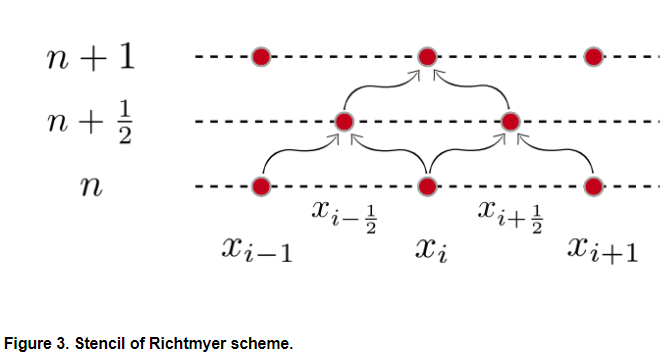

In [9]:
#implementing the Richtmeyr scheme
def richtmyer(U0, nt, dt, dx):


    U_hist = [U0.copy()]
    U = U0.copy()
    U_star = U.copy() #here U_star = U(n+1/2) values

    for n in range(nt):
    
        F = flux(U)
        U_star[:,1:] = 0.5*(U[:,1:] + U[:,:-1]) - (dt/(2*dx))*(F[:,1:] - F[:,:-1])
        #print(U_star)
        F = flux(U_star)
        #print(F)
        U[:,:-1] = U[:,:-1] - (dt/dx)*(F[:,1:] - F[:,:-1])
        #U[:, 0] = U[:, 1]
        #U[:, -1] = U[:, -2]
    
        U_hist.append(U.copy())
    
    return U_hist

In [10]:
#Computing the U values using richtmyer scheme
U_hist_1 = richtmyer(U0, nt, dt, dx)

In [19]:
#Extrating the rho, u and P values from U_hist list
rho_values_1 = U_hist_1[50][0,:]
u_values_1 = U_hist_1[50][1,:]/U_hist_1[50][0,:]
P_values_1 = 0.4*(U_hist_1[50][2,:] - 0.5*((U_hist_1[50][1,:]**2)/U_hist_1[50][0,:]))

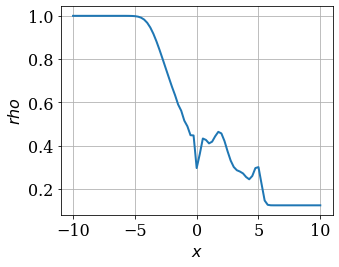

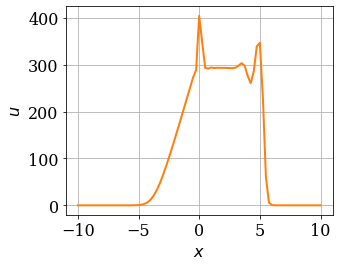

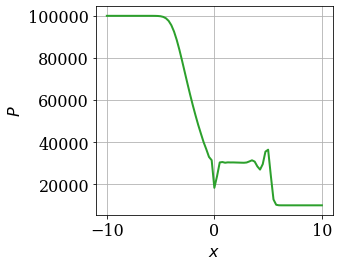

In [13]:
#Plotting rho at t=0.01s
fig_rho_2 = pyplot.figure(figsize=(5.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$rho$')
pyplot.grid()
line_rho_2 = pyplot.plot(x, rho_values_1,
                   color='C0', linestyle='-', linewidth=2)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

#Plotting u at t=0.01s
fig_u_2 = pyplot.figure(figsize=(5.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$u$')
pyplot.grid()
line_u_2 = pyplot.plot(x, u_values_1, 
                    color = 'C1', linestyle = '-', linewidth = 2)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(0.0, 150.0)
pyplot.tight_layout()

#Plotting P at t=0.01s
fig_P_2 = pyplot.figure(figsize=(5.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$P$')
pyplot.grid()
line_P_2 = pyplot.plot(x, P_values_1, 
                    color = 'C2', linestyle = '-', linewidth = 2)[0]
#pyplot.xlim(0.0, L)
#pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

In [14]:
from matplotlib import animation
from IPython.display import HTML

In [15]:
def update_plot(n, U_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    """
    #updating rho values on plot
    fig_rho.suptitle('Time step {:0>2}'.format(n))
    line_rho.set_ydata(U_hist[n][0,:])
    #updating u values on plot
    fig_u.suptitle('Time step {:0>2}'.format(n))
    line_u.set_ydata(U_hist[n][1,:]/U_hist[n][0,:])
    #updating P values on plot
    fig_P.suptitle('Time step {:0>2}'.format(n))
    line_P.set_ydata(0.4*(U_hist[n][2,:] - 0.5*((U_hist[n][1,:]**2)/U_hist[n][0,:])))

In [16]:
# Create an animation of the density in shock tube.
anim = animation.FuncAnimation(fig_rho, update_plot,
                               frames=nt, fargs=(U_hist_1,),
                               interval=50)

# Display the video.
HTML(anim.to_html5_video())

In [17]:
# Create an animation of the velocity in shock tube.
anim = animation.FuncAnimation(fig_u, update_plot,
                               frames=nt, fargs=(U_hist_1,),
                               interval=50)
# Display the video
HTML(anim.to_html5_video())

In [18]:
# Create an animation of the pressure in shock tube.
anim = animation.FuncAnimation(fig_P, update_plot,
                               frames=nt, fargs=(U_hist_1,),
                               interval=50)
# Display the video
HTML(anim.to_html5_video())